In [39]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras.layers import Input, Dense, Flatten, Lambda, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse

tf.random.set_seed(1)

In [59]:
def showimg(img, ax, title=None, vmin=0, vmax=1):
    ax.imshow(img.squeeze(), vmin=vmin, vmax=vmax)
    ax.set_title(title)
    ax.axis('off')

In [41]:
(train_img,train_class),(test_img,test_class)=tf.keras.datasets.mnist.load_data()

train_img=train_img[(train_class==8) | (train_class==7)]
test_img=test_img[(test_class==8) | (test_class==7)]

height,width=28,28
train_img=train_img.reshape(train_img.shape[0],height,width,1).astype('float32')
train_img/=255

test_img=test_img.reshape(test_img.shape[0],height,width,1).astype('float32')
test_img/=255

train_buffer=60000
test_buffer=10000

batch_size=100
latent_dimensions=32

In [42]:
from keras.preprocessing.image import ImageDataGenerator

datagen=ImageDataGenerator(rotation_range=20,width_shift_range=0.2,height_shift_range=0.2,
                             shear_range=0.0,zoom_range=[1.5,2.5])

gen=datagen.flow(train_img,None,batch_size=1)

num=60000
comps=2
components=np.array([[gen.next()[0, ..., 0] for j in range(num)] for i in range(comps)])
blended=components.sum(axis=0)
blended=blended.reshape(blended.shape[0],height,width,1).astype('float32')
components = components.reshape(2,blended.shape[0],height,width,1).astype('float32')

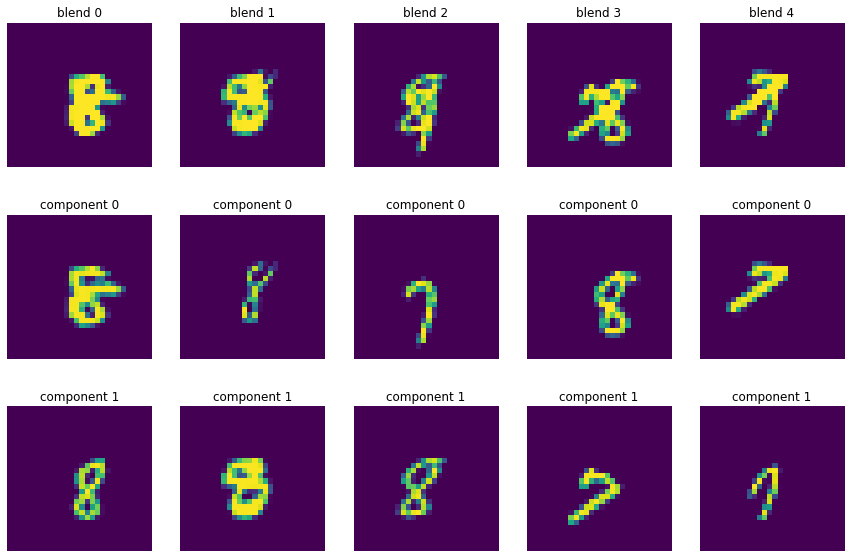

In [43]:
n=5
fig,ax=plt.subplots(3,n,figsize=(3*n, 10))
for i in range(n):
    showimg(blended[i],ax[0,i],f'blend {i}')
    for j in range(comps):
        showimg(components[j,i],ax[j+1,i],f'component {j}')  

In [44]:
def encoder(x):
    x=Conv2D(32,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
    #x=MaxPooling2D()(x)
    return x

In [45]:
def decoder(x):
    #x=UpSampling2D()(x)
    x=Conv2DTranspose(64,3,activation='relu',padding='same',strides=2)(x)
    x=Conv2DTranspose(32,3,activation='relu',padding='same',strides=2)(x)
    return x

In [46]:
def sampling(args):
    z_mean,z_log_sigma=args
    epsilon=tf.random.normal(shape=tf.shape(z_mean))
    z=z_mean+tf.exp(0.5*z_log_sigma)*epsilon
    return z

In [47]:
#encoder
inputs=Input(shape=(height,width,1))

encoded=encoder(inputs)
shape=encoded.get_shape()[1:]
encoded=Flatten()(encoded)

z_mean=Dense(latent_dimensions)(encoded)
z_log_sigma=Dense(latent_dimensions)(encoded)
z=Lambda(sampling)([z_mean,z_log_sigma])

#decoder
input_embed=Input(shape=latent_dimensions)

embed1=Dense(np.prod(shape),activation='relu')(input_embed)
embed1=Reshape(shape)(embed1)
decoded1=decoder(embed1)
output1=Conv2DTranspose(1,3,padding='same')(decoded1)

embed2=Dense(np.prod(shape),activation='relu')(input_embed)
embed2=Reshape(shape)(embed2)
decoded2=decoder(embed2)
output2=Conv2DTranspose(1,3,padding='same')(decoded2)

In [48]:
encode=Model(inputs,z)
encode.summary()

input_comp1=Input(shape=(height,width,1))
input_comp2=Input(shape=(height,width,1))

decode=Model([input_embed,input_comp1,input_comp2],[output1,output2])
decode.summary()

Model: "functional_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 14, 14, 32)   320         input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 7, 7, 64)     18496       conv2d_4[0][0]                   
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 3136)         0           conv2d_5[0][0]                   
______________________________________________________________________________________

In [49]:
encoding=encode(inputs) #define the network
re1,re2=decode([encoding,input_comp1,input_comp2])

vae=Model([inputs,input_comp1,input_comp2],[re1,re2]) #adds methods of the network
vae.summary()

Model: "functional_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
functional_13 (Functional)      (None, 32)           219584      input_9[0][0]                    
__________________________________________________________________________________________________
input_11 (InputLayer)           [(None, 28, 28, 1)]  0                                            
__________________________________________________________________________________________________
input_12 (InputLayer)           [(None, 28, 28, 1)]  0                                            
______________________________________________________________________________________

In [50]:
mse_loss1=tf.reduce_mean((mse(input_comp1,re1)+mse(input_comp2,re2))/2,axis=(1,2))
mse_loss2=tf.reduce_mean((mse(input_comp2,re1)+mse(input_comp1,re2))/2,axis=(1,2))
mse_loss=tf.reduce_mean(tf.minimum(mse_loss1,mse_loss2))*height*width
vae.add_loss(mse_loss)
vae.add_metric(mse_loss,'mse_loss')

beta=0.1
kl_loss=tf.reduce_mean(-0.5*(1+z_log_sigma-tf.square(z_mean)-tf.exp(z_log_sigma)))*beta
vae.add_loss(kl_loss)
vae.add_metric(kl_loss,'kl_loss')

together=[blended,components[0],components[1]]

vae.compile(optimizer=Adam())

In [51]:
history=vae.fit(together,verbose=1,epochs=10,batch_size=batch_size)

Epoch 1/10
600/600 [==============================] - 52s 87ms/step - loss: 9.8074 - mse_loss: 9.5941 - kl_loss: 0.2133
Epoch 2/10
600/600 [==============================] - 51s 85ms/step - loss: 6.9986 - mse_loss: 6.7313 - kl_loss: 0.2673
Epoch 3/10
600/600 [==============================] - 49s 81ms/step - loss: 6.4384 - mse_loss: 6.1644 - kl_loss: 0.2740
Epoch 4/10
600/600 [==============================] - 52s 86ms/step - loss: 6.1474 - mse_loss: 5.8695 - kl_loss: 0.2779
Epoch 5/10
600/600 [==============================] - 52s 86ms/step - loss: 5.9417 - mse_loss: 5.6612 - kl_loss: 0.2805
Epoch 6/10
600/600 [==============================] - 53s 88ms/step - loss: 5.7890 - mse_loss: 5.5060 - kl_loss: 0.2829
Epoch 7/10
600/600 [==============================] - 54s 89ms/step - loss: 5.6606 - mse_loss: 5.3760 - kl_loss: 0.2847
Epoch 8/10
600/600 [==============================] - 53s 88ms/step - loss: 5.5652 - mse_loss: 5.2781 - kl_loss: 0.2871
Epoch 9/10
600/600 [====================

In [62]:
def summary_plot(n,inputs,decode,seed=1):
    np.random.seed(seed)
    #idx=np.array([0,1,2,3,4])
    idx = np.random.choice(len(inputs[0]), size=n, replace=False)
    print(idx)
    input_img = inputs[0][idx]
    comp1,comp2=inputs[1][idx],inputs[2][idx]
    z = encode.predict(input_img)
    output_img1,output_img2 = decode.predict([z,comp1,comp2])
    fig, ax = plt.subplots(6, n, figsize=((3)*n,15))
    for i in range(n):
        encoding = ', '.join(f'{zi:.2f}' for zi in z[i][:3]) + ', ...'
        showimg(input_img[i], ax[0, i], f'blend {idx[i]}')
        showimg(comp1[i], ax[1, i], f'comp1 {idx[i]}')
        showimg(comp2[i], ax[2, i], f'comp2 {idx[i]}')
        showimg(output_img1[i], ax[3, i], f'output1\n{encoding}')
        showimg(output_img2[i], ax[4, i], f'output2\n{encoding}')
        showimg(output_img1[i] + output_img2[i], ax[5, i], f'outblend\n{encoding}')
    return idx

[15281 21435 44536 13518 47529]


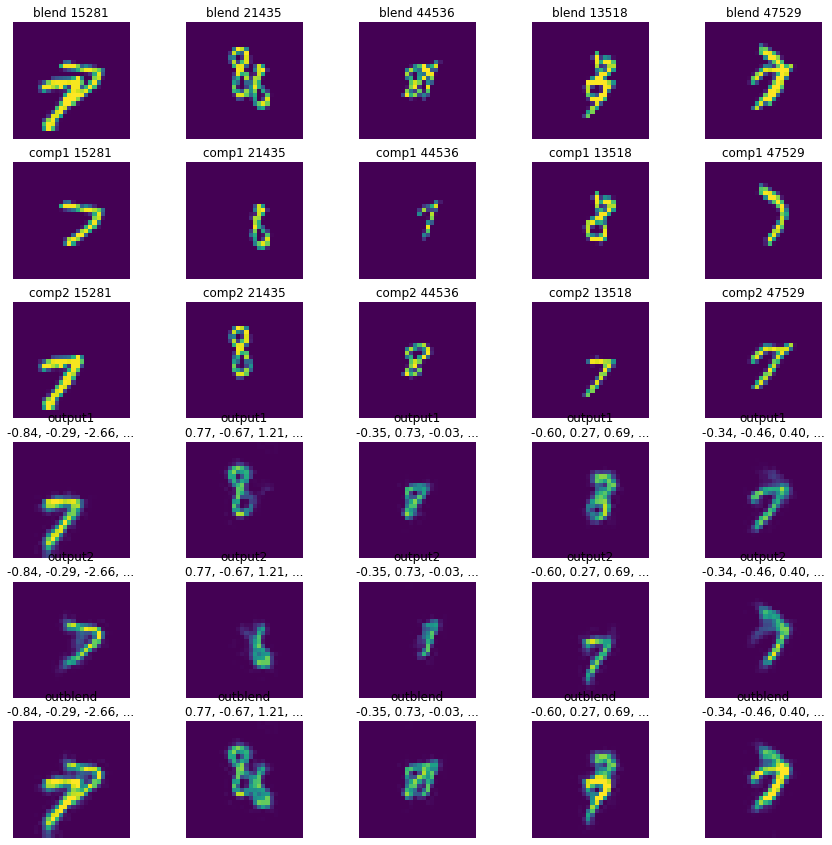

In [63]:
chosen=summary_plot(n,together,decode)